In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.misc import logsumexp
#%matplotlib qt5
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 18})

## Gaussian Mixture Model (GMM)
* probability density finction
$$
\large
\DeclareMathOperator{\Norm}{\mathcal{N}}
\DeclareMathOperator{\Gam}{Gam}
\DeclareMathOperator{\e}{exp}
p(x|\{\mu_c\}, \{\sigma_c^2\}, \{\pi_c\}) = \sum_{c=1}^{C} \Norm(x|\mu_c, \sigma^2_c) \pi_c $$

where
* $\{\mu_c\}$ is the set of $C$ means
* $\{\sigma_c^2\}$ is the set of $C$ variances
* $\{\pi_c\}$ is set of $C$ weights such that $\sum_{c=1}^C \pi_c = 1$

and single variate Gasussian distribution

$$
\large
p(x \mid \mu, \sigma^2) = \Norm(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \e\left\{ \frac{-(x - \mu)^2}{2\sigma^2} \right\}
$$


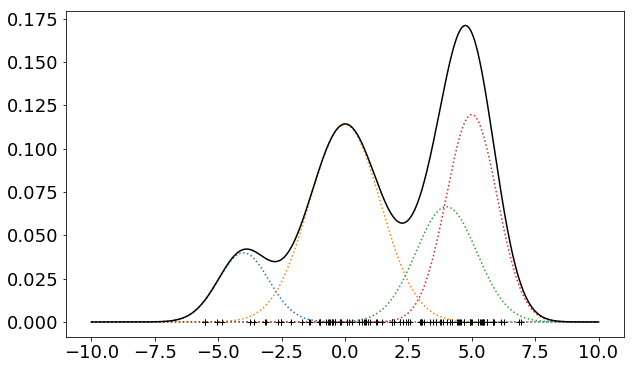

In [2]:
# Plot GMM pdf together with the individual components pdfs; return the GMM pdf line
def plot_GMM(t, mus, sigmas, pis):
  p_xz = sps.norm.pdf(t[:,np.newaxis], mus, sigmas) * pis # all GMM components are evaluated at once
  px = np.sum(p_xz, axis=1)
  plt.plot(t, p_xz, ':')
  plt.plot(t, px, 'k')
  return px


#Handcraft some GMM parameter 
mus = [-4.0, 0.0, 4.0, 5]
sigmas = [1.0, 1.4, 1.2, 1]
pis = [0.1, 0.4, 0.2, 0.3]

t = np.linspace(-10,10,1000)
true_GMM_pdf = plot_GMM(t, mus, sigmas, pis)

# Generate N datapoints from this GMM
N = 100
Nc = sps.multinomial.rvs(N, pis) # Draw observation counts for each component from multinomial distribution
x = sps.norm.rvs(np.repeat(mus, Nc), np.repeat(sigmas, Nc))
np.random.shuffle(x)
plt.plot(x, np.zeros_like(x), '+k');

## GMM - EM algorithm
* E-step

$$
\large
\DeclareMathOperator{\Norm}{\mathcal{N}}
\DeclareMathOperator{\eeta}{\boldsymbol{\eta}}
\gamma_{nc}=P(z_n=c|x_n,\eeta^{old})=\frac{p(x_n|z_n=c,\eeta^{old})P(z_n=c|\eeta^{old})}{p(x_n|\eeta^{old})}
=\frac{\mathcal{N}(x_n|\mu_c^{old}{\sigma_c^2}^{old})\pi_c^{old}}{\sum_{k}\mathcal{N}(x_n|\mu_{k}^{old},{\sigma_{k}^2}^{old})\pi_{k}^{old}}
$$

* M-step

$$
\large
\begin{align}
\mu_c^{new}        & =\frac{\sum_n \gamma_{nc}x_n}{\sum_n \gamma_{nc}}\\
{\sigma_c^2}^{new} & =\frac{\sum_n \gamma_{nc}(x_n-\mu_c^{new})^2}{\sum_n \gamma_{nc}}\\
\pi_c              & =\frac{\sum_n \gamma_{nc}}{N}
\end{align}
$$

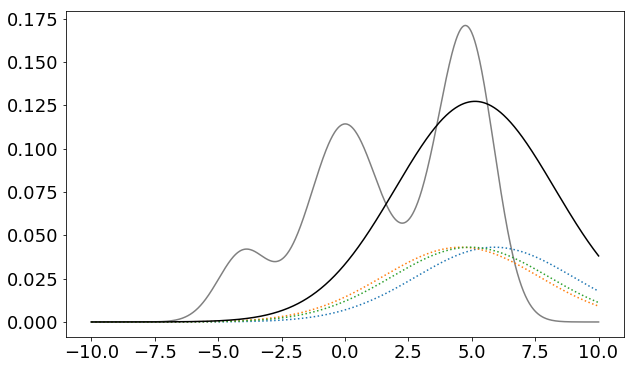

In [3]:
#Choose some initial parameters
C = 3        # number of GMM components 
mus = x[:C]  # we choose few first observations as the initial means
sigmas = np.repeat(np.std(x), C) # sigma for all components is set to std of the the training data
pis = np.ones(C)/C

plt.clf()
plt.plot(t, true_GMM_pdf, 'gray')
plot_GMM(t, mus, sigmas, pis);


Training data log likelihood: -307.894366448
Training data log likelihood: -254.248283842
Training data log likelihood: -254.063322246
Training data log likelihood: -253.853034278
Training data log likelihood: -253.579197513
Training data log likelihood: -253.219791117
Training data log likelihood: -252.750189657
Training data log likelihood: -252.133612054
Training data log likelihood: -251.315692856
Training data log likelihood: -250.236724398
Training data log likelihood: -248.897207185
Training data log likelihood: -247.471032115
Training data log likelihood: -246.261781713
Training data log likelihood: -245.438419912
Training data log likelihood: -244.961262908
Training data log likelihood: -244.711109308
Training data log likelihood: -244.582557373
Training data log likelihood: -244.51051977
Training data log likelihood: -244.462769977
Training data log likelihood: -244.425397943
Training data log likelihood: -244.392737549
Training data log likelihood: -244.362419688
Training da

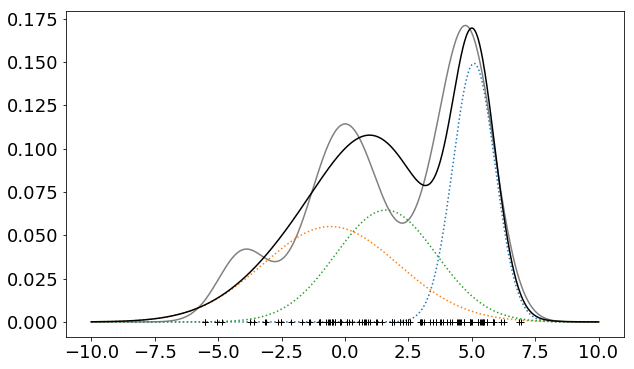

In [4]:
for _ in range(50):
  #E-step
  log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus, sigmas) + np.log(pis)
  log_p_x = logsumexp(log_p_xz, axis=1, keepdims=True)
  print("Training data log likelihood:", log_p_x.sum())

  gammas = np.exp(log_p_xz - log_p_x)
  #M-step
  Nc = gammas.sum(axis=0)
  mus =  x.dot(gammas) / Nc
  sigmas =  np.sqrt((x**2).dot(gammas) / Nc - mus**2) # we use std, not variance!
  pis = Nc / Nc.sum()
    
plot_GMM(t, mus, sigmas, pis)

plt.clf()
plt.plot(t, true_GMM_pdf, 'gray')
plot_GMM(t, mus, sigmas, pis);
plt.plot(x, np.zeros_like(x), '+k');